In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from math import comb  # Combinations
from itertools import combinations

from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from utils.ae_torch_classes import *
from utils.LSTM_gesture_classifier import *

In [2]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

In [3]:
print("Loading")

# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\saved_datasets\\"
model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\Embedding\\Autoencoders\\'
metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\saved_datasets\\metadata_cols_df.pkl')
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"
#model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\'
#metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

emg_dir = "filtered_datasets\\EMG_PPD\\"
both_dir = "filtered_datasets\\Both_PPD\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)


Loading


In [4]:
num_rows_per_gesture = 64 # From the interp
batch_size = 32

## Train/test Split
> Train set:

        - Full dataset XOR all testsets
> Test sets:

        - Last 2 trials of all gestures
        - Hold out 5 users

In [5]:
combined_emg_df = pd.concat([metadata_cols_df, pd.concat([emg_training_users_df, emg_test_users_df])], axis=1)

print(combined_emg_df.shape)
combined_emg_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [6]:
unique_gestures = combined_emg_df['Gesture_ID'].unique()
unique_gestures

array(['pan', 'duplicate', 'zoom-out', 'zoom-in', 'move', 'rotate',
       'select-single', 'delete', 'close', 'open'], dtype=object)

Held Out Users Test Set

In [7]:
combined_emg_df['Participant'].unique()

array(['P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109',
       'P110', 'P111', 'P112', 'P114', 'P115', 'P116', 'P118', 'P119',
       'P121', 'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 'P128',
       'P131', 'P132', 'P004', 'P005', 'P006', 'P008', 'P010', 'P011'],
      dtype=object)

In [8]:
held_out_users_lst = ['P104', 'P108', 'P112', 'P116', 'P122', 'P124']
num_test_users = len(held_out_users_lst)
num_train_users = len(combined_emg_df['Participant'].unique()) - num_test_users
heldoutusers_testset = combined_emg_df[combined_emg_df['Participant'].isin(held_out_users_lst)].reset_index(drop=True)

print(heldoutusers_testset.shape)
heldoutusers_testset.head()

(38400, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P104,duplicate,1,-0.836866,-0.069462,-1.201111,-3.266425,-0.143297,-0.012325,-0.246586,-0.874835,-0.903565,-0.139702,-1.199692,-1.301382,-0.065817,-0.008174,-0.002584,-0.011676
1,P104,duplicate,1,-0.780875,-0.082351,-1.208023,-3.258212,-0.110423,0.003053,-0.248364,-1.083834,-0.897283,-0.124933,-1.195211,-1.293138,0.006040,0.004724,0.019656,-0.012380
2,P104,duplicate,1,-0.830069,-0.081989,-1.250259,-3.157837,-0.129984,0.019836,-0.245799,-1.099313,-0.811197,-0.097231,-1.089515,-1.219655,-0.024191,0.015596,-0.015494,0.036700
3,P104,duplicate,1,-0.913201,-0.070693,-1.233590,-2.898543,-0.208200,0.010882,-0.219394,-1.123904,-0.798595,-0.105790,-0.904317,-1.281031,-0.068723,0.011252,-0.005082,0.080905
4,P104,duplicate,1,-0.808832,-0.066996,-1.088678,-2.514705,-0.155542,0.002881,-0.109496,-0.220264,-0.821522,-0.105144,-0.440872,-1.288635,-0.060873,-0.015651,0.004653,0.041557


Last 2 Trials Test Set

In [9]:
import random

def generate_non_repetitive_numbers(n):
    # Generate a list of unique random numbers from 1 to 10
    numbers = random.sample(range(1, 11), n)
    numbers_as_strings_lst = [str(num) for num in numbers]
    return numbers_as_strings_lst

sample_size = 9
held_out_trials_lst = generate_non_repetitive_numbers(sample_size)
print(held_out_trials_lst)

['9', '1', '7', '2', '5', '8', '6', '3', '10']


In [10]:
# Should I be choosing random numbers? 9 and 10 are later so may be different from earlier trials...
# Let's try 4 and 7 instead...
#held_out_trials_lst = ['4', '7']
# ^ SWITCHED TO RANDOM SAMPLES ABOVE! 

num_train_trials = 10 - len(held_out_trials_lst)

heldouttrials_testset = combined_emg_df[combined_emg_df['Gesture_Num'].isin(held_out_trials_lst)].reset_index(drop=True)

print(heldouttrials_testset.shape)
heldouttrials_testset.head()

(184320, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


Remove test users from held out trials (dont double dip test sets...)

In [11]:
heldouttrials_testset

# Drop rows where 'Participant' is in participants_to_drop
heldouttrials_testset = heldouttrials_testset[~heldouttrials_testset['Participant'].isin(held_out_users_lst)].reset_index(drop=True)

print(heldouttrials_testset.shape)
heldouttrials_testset.head()

(149760, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


Make train set now!

In [12]:
# Concatenate the smaller dataframes
combined_testsets = pd.concat([heldouttrials_testset, heldoutusers_testset]).drop_duplicates()

# Perform the anti-join
result_df = combined_emg_df.merge(combined_testsets, on=['Participant', 'Gesture_ID', 'Gesture_Num', 'EMG1', 'EMG2', 'EMG3',
                                                   'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG9', 'EMG10', 'EMG11',
                                                   'EMG12', 'EMG13', 'EMG14', 'EMG15', 'EMG16'],
                           how='left', indicator=True)
trainset = result_df[result_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# Display the result
print(trainset.shape)
trainset.head()

(16640, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
192,P102,pan,4,-0.549235,-0.916534,-0.525121,-0.225610,-0.333053,-0.760832,-0.375548,-0.062929,-0.920086,-2.385653,-0.381550,-0.731687,-0.268114,-0.740772,-0.129833,-0.103633
193,P102,pan,4,-0.490476,-0.890864,-0.483957,-0.225391,-0.214160,-0.579567,-0.256789,-0.087063,-0.702393,-3.445693,-0.257704,0.042039,-0.314467,-1.443360,0.066790,-0.013539
194,P102,pan,4,-0.514758,-0.890326,-0.451366,-0.185288,-0.066625,-0.421072,-0.291759,-0.034548,-0.506846,-3.134198,-0.350304,-0.132754,-0.268009,-2.053143,0.060545,0.006590
195,P102,pan,4,-0.536191,-0.864666,-0.372611,-0.103400,-0.037901,-0.213140,-0.286353,0.018436,-0.264826,-3.101445,-0.404368,4.729111,-0.164762,-0.629966,-0.092068,-0.054365
196,P102,pan,4,-0.241157,-0.623542,0.007789,-0.055446,-0.009482,-0.143867,-0.215939,0.076685,-0.147219,-3.332459,-0.486141,5.866592,-0.182525,-0.123562,0.087061,0.008114


In [13]:
trainset_metadata = trainset.iloc[::num_rows_per_gesture, :3]

print(trainset_metadata.shape)
trainset_metadata.head()

(260, 3)


,Participant,Gesture_ID,Gesture_Num
192,P102,pan,4
832,P102,duplicate,4
1472,P102,zoom-out,4
2112,P102,zoom-in,4
2752,P102,move,4


Encode the labels

In [14]:
# THESE ARE LABELS BY GESTURE!

label_encoder = LabelEncoder()
label_encoder.fit(unique_gestures)

# Transform the gesture labels in each dataset
train_labels = label_encoder.transform(trainset['Gesture_ID'].iloc[::num_rows_per_gesture])
testHOT_labels = label_encoder.transform(heldouttrials_testset['Gesture_ID'].iloc[::num_rows_per_gesture])
testHOU_labels = label_encoder.transform(heldoutusers_testset['Gesture_ID'].iloc[::num_rows_per_gesture])

print(f"train_labels shape: {train_labels.shape}")
print(f"testHOT_labels shape: {testHOT_labels.shape}")
print(f"testHOU_labels shape: {testHOU_labels.shape}")


train_labels shape: (260,)
testHOT_labels shape: (2340,)
testHOU_labels shape: (600,)


In [15]:
train_labels[:5]

array([5, 2, 9, 8, 3])

In [16]:
testHOT_labels[:5]

array([5, 5, 5, 5, 5])

In [17]:
testHOU_labels[:5]

array([2, 2, 2, 2, 2])

In [18]:
# CREATE THE TRAINING SET
num_train_gestures = len(trainset) // num_rows_per_gesture
num_emg_features = emg_training_users_df.shape[1]
num_HOT_gestures = len(heldouttrials_testset) // num_rows_per_gesture
num_HOU_gestures = len(heldoutusers_testset) // num_rows_per_gesture

print(num_train_gestures)
print(num_HOT_gestures)
print(num_HOU_gestures)

260
2340
600


In [19]:
X_3DTensor_full_emg = torch.tensor(trainset.iloc[:,3:].to_numpy().reshape(num_train_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)
Xtest_3DTensor_HOT = torch.tensor(heldouttrials_testset.iloc[:,3:].to_numpy().reshape(num_HOT_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)
Xtest_3DTensor_HOU = torch.tensor(heldoutusers_testset.iloc[:,3:].to_numpy().reshape(num_HOU_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)


In [20]:
hidden_dim_lst = [9]
input_dim = 16
RNNAE_9mir_EMGFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=num_rows_per_gesture, progressive=False, mirror=True)
RNNAE_9mir_EMGFull.load_state_dict(torch.load(model_dir_path+'RNNAE_9mir_vallossp277_EMGFull.pth'))

<All keys matched successfully>

These are the input data embeddings

In [21]:
X_emg_train_embeddings = RNNAE_9mir_EMGFull.encode(X_3DTensor_full_emg)
X_emgHOT_test_embeddings = RNNAE_9mir_EMGFull.encode(Xtest_3DTensor_HOT)
X_emgHOU_test_embeddings = RNNAE_9mir_EMGFull.encode(Xtest_3DTensor_HOU)

print(f"X_emg_train_embeddings shape: {X_emg_train_embeddings.shape}")
print(f"X_emgHOT_test_embeddings shape: {X_emgHOT_test_embeddings.shape}")
print(f"X_emgHOU_test_embeddings shape: {X_emgHOU_test_embeddings.shape}")


X_emg_train_embeddings shape: torch.Size([260, 64, 9])
X_emgHOT_test_embeddings shape: torch.Size([2340, 64, 9])
X_emgHOU_test_embeddings shape: torch.Size([600, 64, 9])


In [22]:
520/2/10
# 640 / 2 trials held out per gesture / 10 gestures

# --> 26 is the number of train participants

26.0

In [23]:
num_embedded_emg_features = hidden_dim_lst[-1]

In [24]:
num_train_gestures_per_user = X_emg_train_embeddings.shape[0]//num_train_users
num_HOT_gestures_per_user = X_emgHOT_test_embeddings.shape[0]//num_train_users
num_HOU_gestures_per_user = X_emgHOU_test_embeddings.shape[0]//num_test_users

print(num_train_gestures_per_user)
print(num_HOT_gestures_per_user)
print(num_HOU_gestures_per_user)

10
90
100


- Each participant has their our HOT dataset and label set
- All participants share and test on the same HOU dataset and label set (these users are necessarily held out of the trianing user set to begin with)

In [25]:
ptrain_3D_dict = dict()
ptest_HOT3D_dict = dict()

ptrain_2D_dict = dict()
ptest_HOT2D_dict = dict()

ptrain_labels_dict = dict()
ptest_labelsHOT_dict = dict()

for p_idx, pID in enumerate(trainset_metadata['Participant'].unique()):
    lb = int(p_idx*num_train_gestures_per_user)
    ub = int(p_idx*num_train_gestures_per_user+num_train_gestures_per_user)
    HOT_lb = int(p_idx*num_HOT_gestures_per_user)
    HOT_ub = int(p_idx*num_HOT_gestures_per_user+num_HOT_gestures_per_user)
    print(f"pID: {pID}; lb: {lb}; ub: {ub}; HOT_lb: {HOT_lb}; HOT_lb: {HOT_lb}.")
    
    ptrain_3D_dict[pID] = X_emg_train_embeddings[lb:ub, :, :]
    ptest_HOT3D_dict[pID] = X_emgHOT_test_embeddings[HOT_lb:HOT_ub, :, :]

    ptrain_2D_dict[pID] = X_emg_train_embeddings[lb:ub, :, :].reshape(num_train_gestures_per_user, -1).detach().numpy()
    ptest_HOT2D_dict[pID] = X_emgHOT_test_embeddings[HOT_lb:HOT_ub, :, :].reshape(num_HOT_gestures_per_user, -1).detach().numpy()

    ptrain_labels_dict[pID] = train_labels[lb:ub]
    ptest_labelsHOT_dict[pID] = testHOT_labels[HOT_lb:HOT_ub]


pID: P102; lb: 0; ub: 10; HOT_lb: 0; HOT_lb: 0.
pID: P103; lb: 10; ub: 20; HOT_lb: 90; HOT_lb: 90.
pID: P105; lb: 20; ub: 30; HOT_lb: 180; HOT_lb: 180.
pID: P106; lb: 30; ub: 40; HOT_lb: 270; HOT_lb: 270.
pID: P107; lb: 40; ub: 50; HOT_lb: 360; HOT_lb: 360.
pID: P109; lb: 50; ub: 60; HOT_lb: 450; HOT_lb: 450.
pID: P110; lb: 60; ub: 70; HOT_lb: 540; HOT_lb: 540.
pID: P111; lb: 70; ub: 80; HOT_lb: 630; HOT_lb: 630.
pID: P114; lb: 80; ub: 90; HOT_lb: 720; HOT_lb: 720.
pID: P115; lb: 90; ub: 100; HOT_lb: 810; HOT_lb: 810.
pID: P118; lb: 100; ub: 110; HOT_lb: 900; HOT_lb: 900.
pID: P119; lb: 110; ub: 120; HOT_lb: 990; HOT_lb: 990.
pID: P121; lb: 120; ub: 130; HOT_lb: 1080; HOT_lb: 1080.
pID: P123; lb: 130; ub: 140; HOT_lb: 1170; HOT_lb: 1170.
pID: P125; lb: 140; ub: 150; HOT_lb: 1260; HOT_lb: 1260.
pID: P126; lb: 150; ub: 160; HOT_lb: 1350; HOT_lb: 1350.
pID: P127; lb: 160; ub: 170; HOT_lb: 1440; HOT_lb: 1440.
pID: P128; lb: 170; ub: 180; HOT_lb: 1530; HOT_lb: 1530.
pID: P131; lb: 180; ub: 

In [26]:
# ptest_HOU3D_dict --> X_emgHOU_test_embeddings
# ptest_HOU2D_dict --> X_emgHOU_test_embeddings.reshape(X_emgHOU_test_embeddings.shape[0], -1).detach().numpy()
#testHOU_labels

In [27]:
using_pytorch=False
k=1  # Change this to k_range in the future...
model_str='KNN'

########################################

participants = list(trainset_metadata['Participant'].unique())
num_participants = len(participants)
pairwise_model_HOTaccuracies_matrix = np.zeros((num_participants, num_participants))
pairwise_model_HOUaccuracies_matrix = np.zeros((num_participants, num_participants))
pairwise_model_AVGaccuracies_matrix = np.zeros((num_participants, num_participants))

# Iterate through every pair of participants
total_num_combos = comb(num_participants, 2)

if using_pytorch:
    testHOU_dataset = TensorDataset(X_emgHOU_test_embeddings, torch.tensor(testHOU_labels, dtype=torch.float32))
    testHOU_loader = DataLoader(testHOU_dataset, batch_size=batch_size, shuffle=False)
else:
    Xtest_HOU = X_emgHOU_test_embeddings.reshape(X_emgHOU_test_embeddings.shape[0], -1).detach().numpy()
    ytest_HOU = testHOU_labels.reshape(-1, 1)  # Make it 2D...
    
for current_combo_idx, (p1, p2) in enumerate(combinations(participants, 2)):
    if current_combo_idx%15==0:
        print(f"Pair {current_combo_idx+1} of {total_num_combos}: ({p1}, {p2})")
    p1_idx = participants.index(p1)
    p2_idx = participants.index(p2)

    if using_pytorch:
        # Create TensorDataset
        # NEED TO ADD LABELS!!!
        # NEED TO CORRECT pID TO p1 and p2 AND THEN CAT THE TENSORS!
        #torch.cat((tensor1, tensor2), dim=0)
        train_dataset = TensorDataset(ptrain_3D_dict[pID], torch.tensor(ptrain_labels_dict[pID], dtype=torch.float32))
        testHOT_dataset = TensorDataset( ptest_HOT3D_dict[pID], torch.tensor(ptest_labelsHOT_dict[pID], dtype=torch.float32))
        
        # Create DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        testHOT_loader = DataLoader(testHOT_dataset, batch_size=batch_size, shuffle=False)

        # LSTM / NN code note added yet...
    
    else:
        Xtrain = np.concatenate((ptrain_2D_dict[p1], ptrain_2D_dict[p2]), axis=0)
        Xtest_HOT = np.concatenate((ptest_HOT2D_dict[p1], ptest_HOT2D_dict[p2]), axis=0)
        
        ytrain = np.concatenate((ptrain_labels_dict[p1].reshape(-1, 1), ptrain_labels_dict[p2].reshape(-1, 1)), axis=0)  # Make it 2D...
        ytest_HOT = np.concatenate((ptest_labelsHOT_dict[p1].reshape(-1, 1), ptest_labelsHOT_dict[p2].reshape(-1, 1)), axis=0)  # Make it 2D...

        if model_str.upper()=='KNN':
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(Xtrain, ytrain)
            
            y_pred = knn.predict(Xtest_HOT)
            HOT_accuracy = accuracy_score(ytest_HOT, y_pred)
            pairwise_model_HOTaccuracies_matrix[p2_idx, p1_idx] = HOT_accuracy
            pairwise_model_HOTaccuracies_matrix[p1_idx, p2_idx] = HOT_accuracy
            #print(f"Pair {current_combo_idx+1} of {total_num_combos}: ({p1}, {p2}): HOT_accuracy: {HOT_accuracy}")
            #print(f"HOT_accuracy: {HOT_accuracy}")
        
            y_pred = knn.predict(Xtest_HOU)
            HOU_accuracy = accuracy_score(ytest_HOU, y_pred)
            pairwise_model_HOUaccuracies_matrix[p2_idx, p1_idx] = HOU_accuracy
            pairwise_model_HOUaccuracies_matrix[p1_idx, p2_idx] = HOU_accuracy
            #print(f"HOU_accuracy: {HOU_accuracy}")

            AVG_accuracy = (HOT_accuracy + HOU_accuracy) / 2
            pairwise_model_AVGaccuracies_matrix[p2_idx, p1_idx] = AVG_accuracy
            pairwise_model_AVGaccuracies_matrix[p1_idx, p2_idx] = AVG_accuracy
        elif model_str.upper()=='SVC':
            svc = SVC(kernel='linear')
            svc.fit(Xtrain, ytrain)
            
            y_pred_HOT = svc.predict(Xtest_HOT)
            HOT_accuracy = accuracy_score(ytest_HOT, y_pred_HOT)
            pairwise_model_HOTaccuracies_matrix[p2_idx, p1_idx] = HOT_accuracy
            pairwise_model_HOTaccuracies_matrix[p1_idx, p2_idx] = HOT_accuracy
            
            y_pred_HOU = svc.predict(Xtest_HOU)
            HOU_accuracy = accuracy_score(ytest_HOU, y_pred_HOU)
            pairwise_model_HOUaccuracies_matrix[p2_idx, p1_idx] = HOU_accuracy
            pairwise_model_HOUaccuracies_matrix[p1_idx, p2_idx] = HOU_accuracy
            
            AVG_accuracy = (HOT_accuracy + HOU_accuracy) / 2
            pairwise_model_AVGaccuracies_matrix[p2_idx, p1_idx] = AVG_accuracy
            pairwise_model_AVGaccuracies_matrix[p1_idx, p2_idx] = AVG_accuracy
        else:
            raise ValueError(f"model_str {model_str} is not supported")
    


Pair 1 of 325: (P102, P103)
Pair 16 of 325: (P102, P127)
Pair 31 of 325: (P103, P111)
Pair 46 of 325: (P103, P006)
Pair 61 of 325: (P105, P125)
Pair 76 of 325: (P106, P111)
Pair 91 of 325: (P106, P006)
Pair 106 of 325: (P107, P127)
Pair 121 of 325: (P109, P119)
Pair 136 of 325: (P110, P111)
Pair 151 of 325: (P110, P006)
Pair 166 of 325: (P111, P132)
Pair 181 of 325: (P114, P128)
Pair 196 of 325: (P115, P127)
Pair 211 of 325: (P118, P127)
Pair 226 of 325: (P119, P128)
Pair 241 of 325: (P121, P132)
Pair 256 of 325: (P123, P006)
Pair 271 of 325: (P126, P127)
Pair 286 of 325: (P127, P006)
Pair 301 of 325: (P131, P006)
Pair 316 of 325: (P005, P006)


Broadcasting

In [32]:
matrix = np.array([
    [1, 10, 100],
    [100, 10, 1],
    [1000, 10000, -1]
])

matrix[:, :, None] - matrix[:, None, :]

array([[[     0,     -9,    -99],
        [     9,      0,    -90],
        [    99,     90,      0]],

       [[     0,     90,     99],
        [   -90,      0,      9],
        [   -99,     -9,      0]],

       [[     0,  -9000,   1001],
        [  9000,      0,  10001],
        [ -1001, -10001,      0]]])

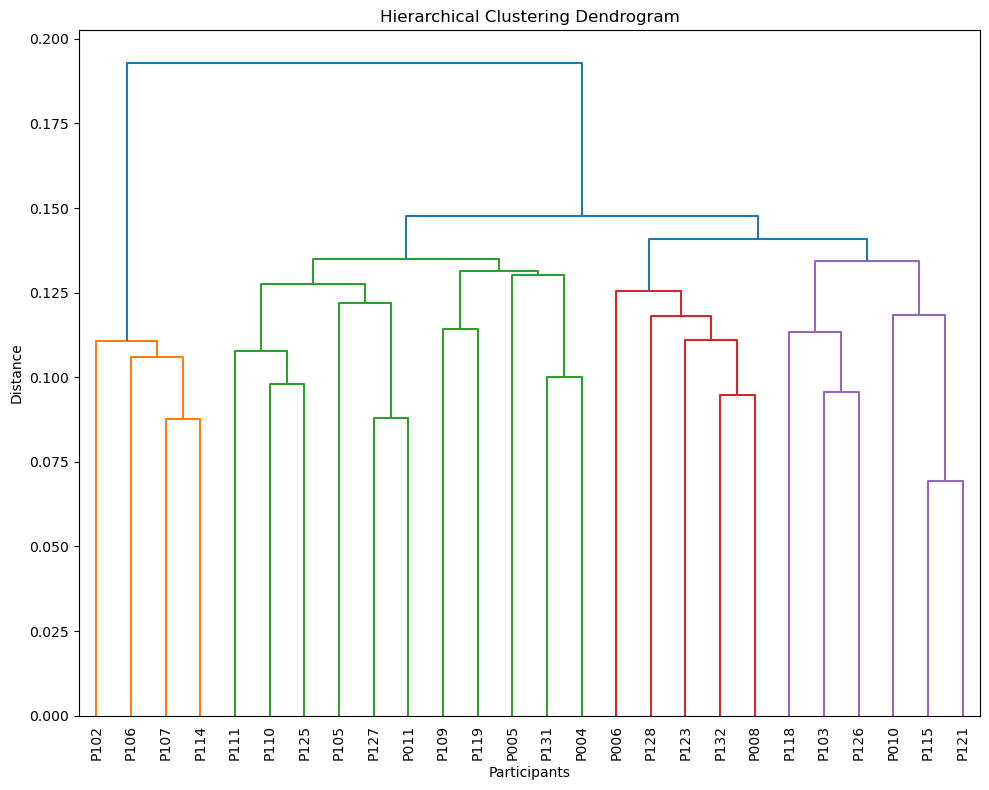

In [28]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Assuming pairwise_model_HOUaccuracies_matrix is your matrix and participants is your list of participants
matrix = np.array(pairwise_model_HOUaccuracies_matrix)

# Calculate the distance matrix based on performance differences
# Here we use absolute difference, but you could use other metrics
distance_matrix = np.abs(matrix[:, :, None] - matrix[:, None, :]).mean(axis=2)

# Perform hierarchical clustering using the distance matrix
linked = linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 8))
dendrogram(linked, labels=participants)
plt.xlabel('Participants')
plt.ylabel('Distance')
plt.title('1 Template: HOT Hierarchical Clustering Dendrogram')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

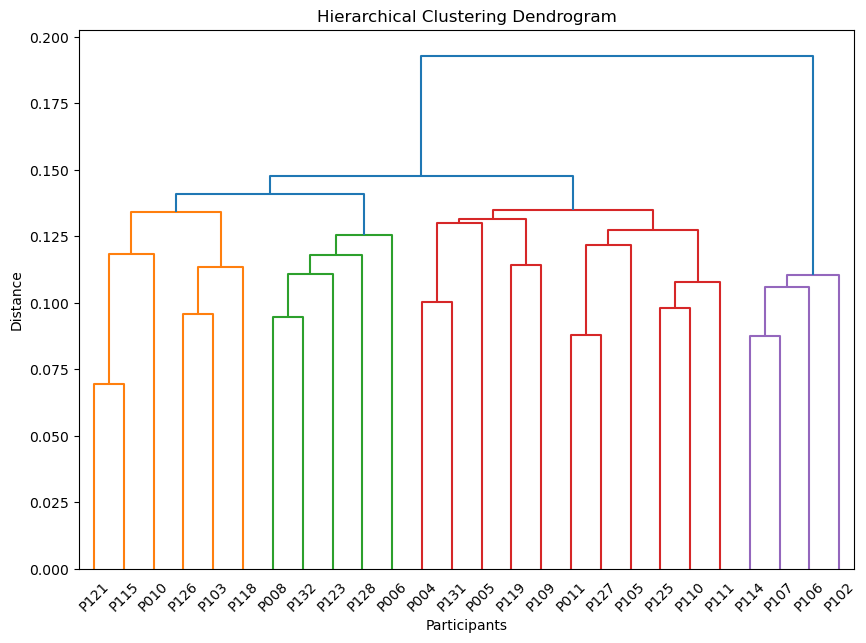

In [29]:
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=participants, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('1 Template: HOT Hierarchical Clustering Dendrogram')
plt.xlabel('Participants')
plt.ylabel('Distance')
plt.show()

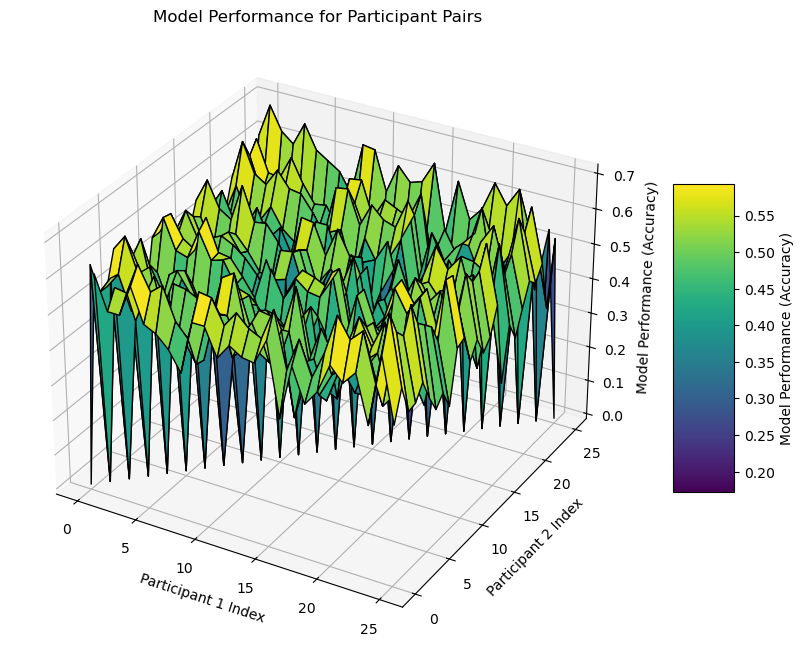

In [31]:
# Create meshgrid for plotting
X, Y = np.meshgrid(np.arange(num_participants), np.arange(num_participants))

# Prepare Z values from the accuracy matrix
Z = pairwise_model_HOTaccuracies_matrix

# Create a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k')

# Add color bar which maps values to colors
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Model Performance (Accuracy)')

# Set labels
ax.set_xlabel('Participant 1 Index')
ax.set_ylabel('Participant 2 Index')
ax.set_zlabel('Model Performance (Accuracy)')
ax.set_title('Model Performance for Participant Pairs')

plt.show()

## Held Out Trials (Templates) Cluster Maps

<Figure size 1000x800 with 0 Axes>

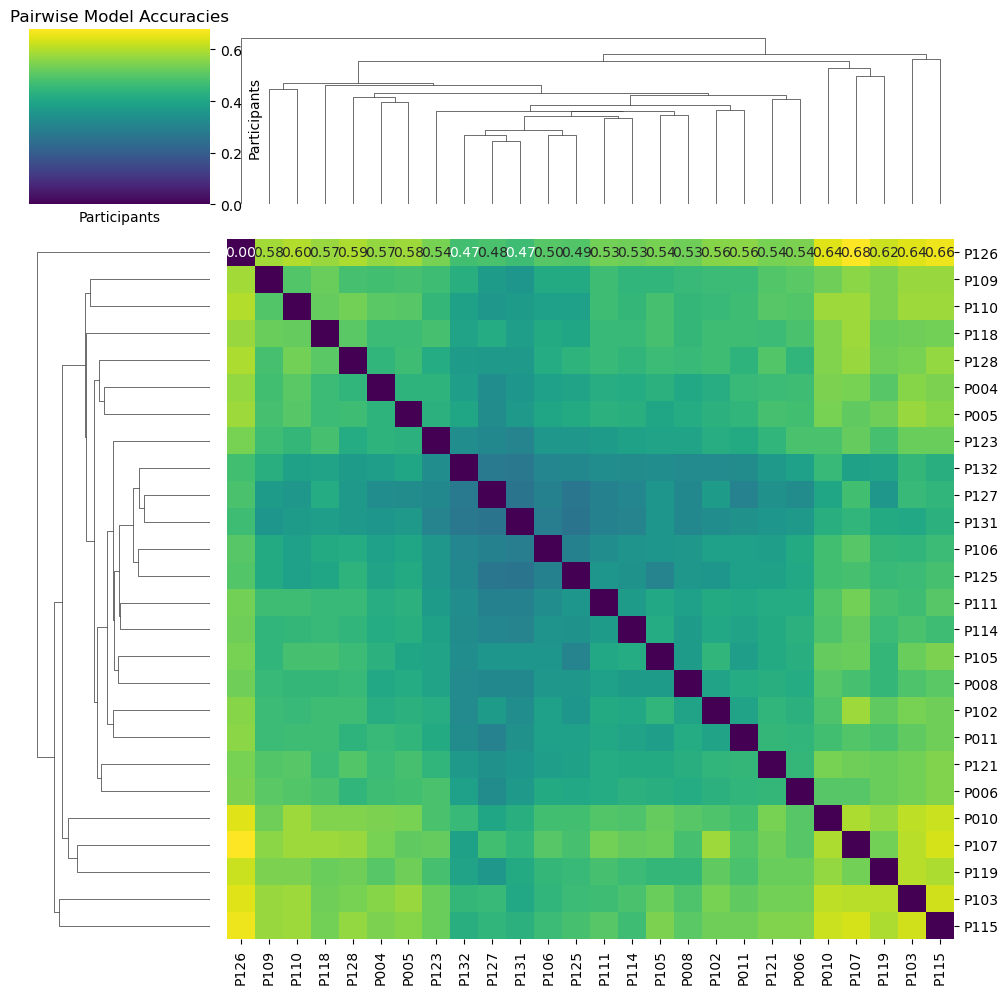

In [69]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOTaccuracies_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

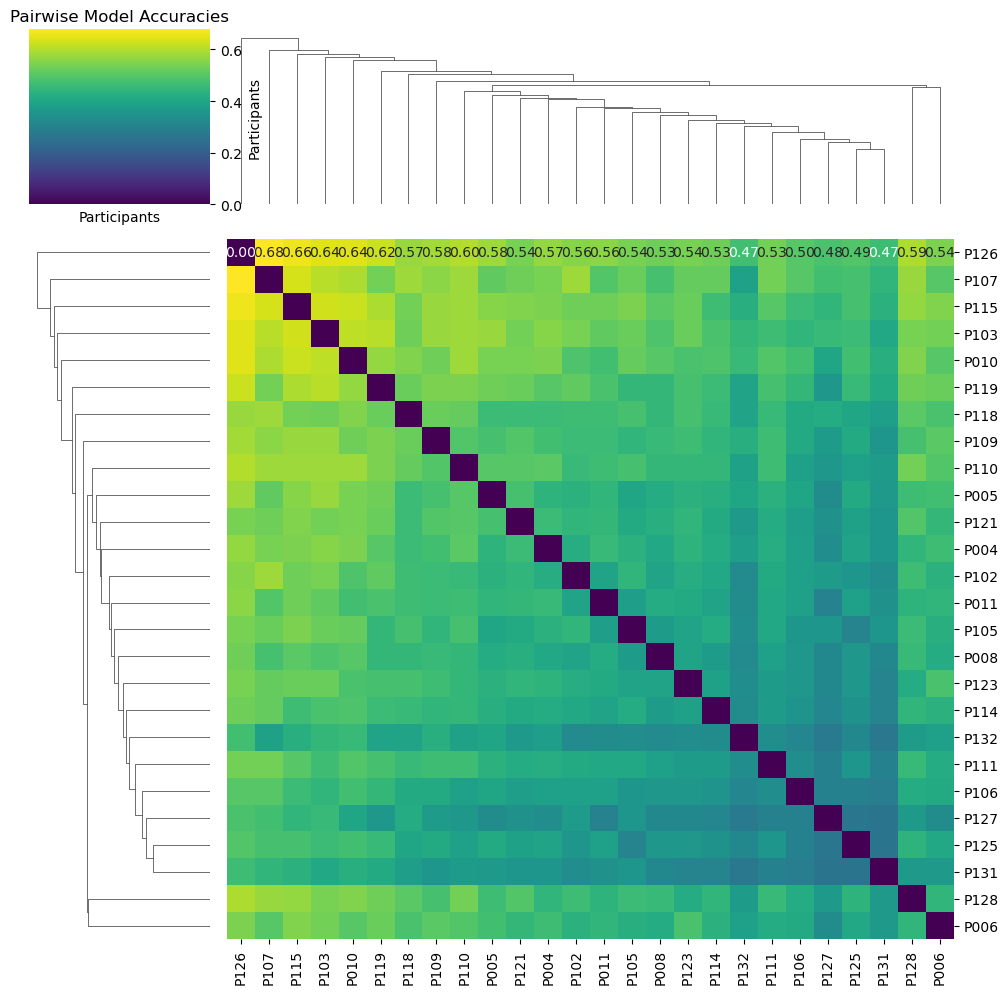

In [70]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOTaccuracies_matrix, metric='correlation', cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

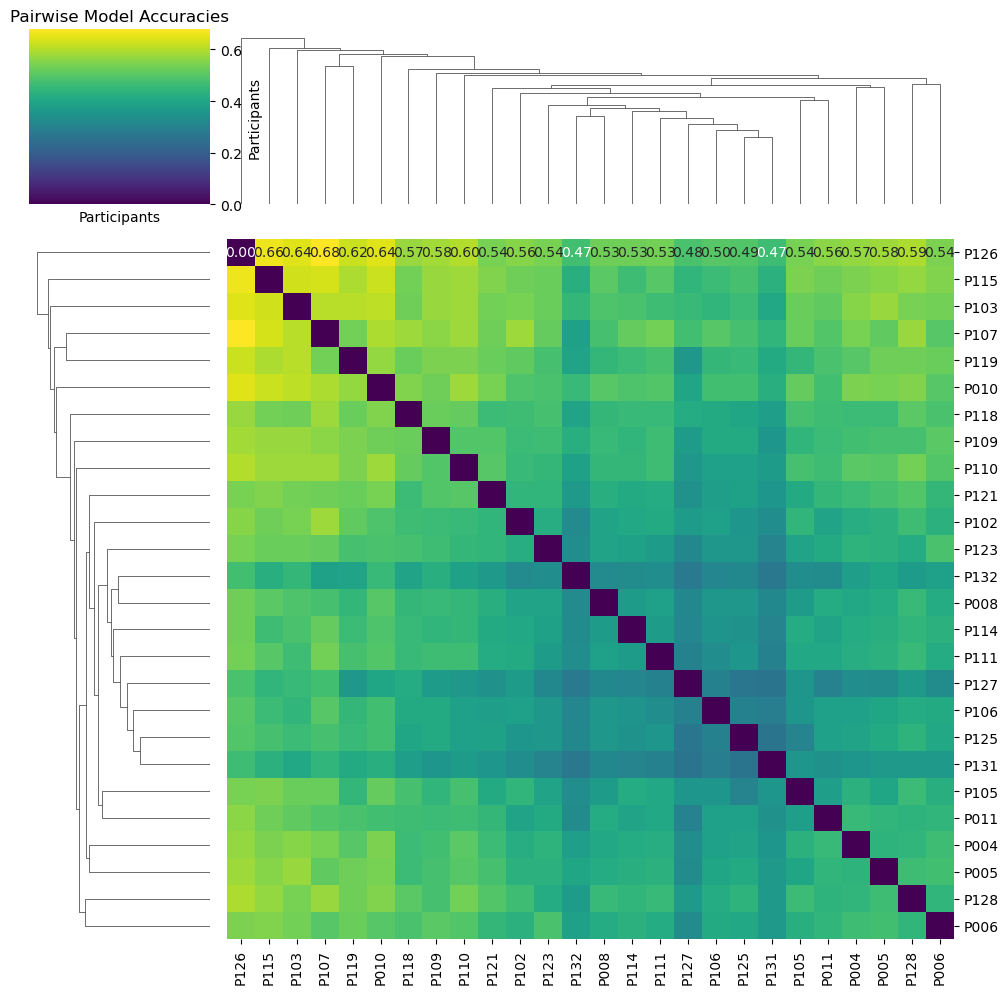

In [71]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOTaccuracies_matrix, metric='cosine', cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Held Out User Cluster Maps

<Figure size 1000x800 with 0 Axes>

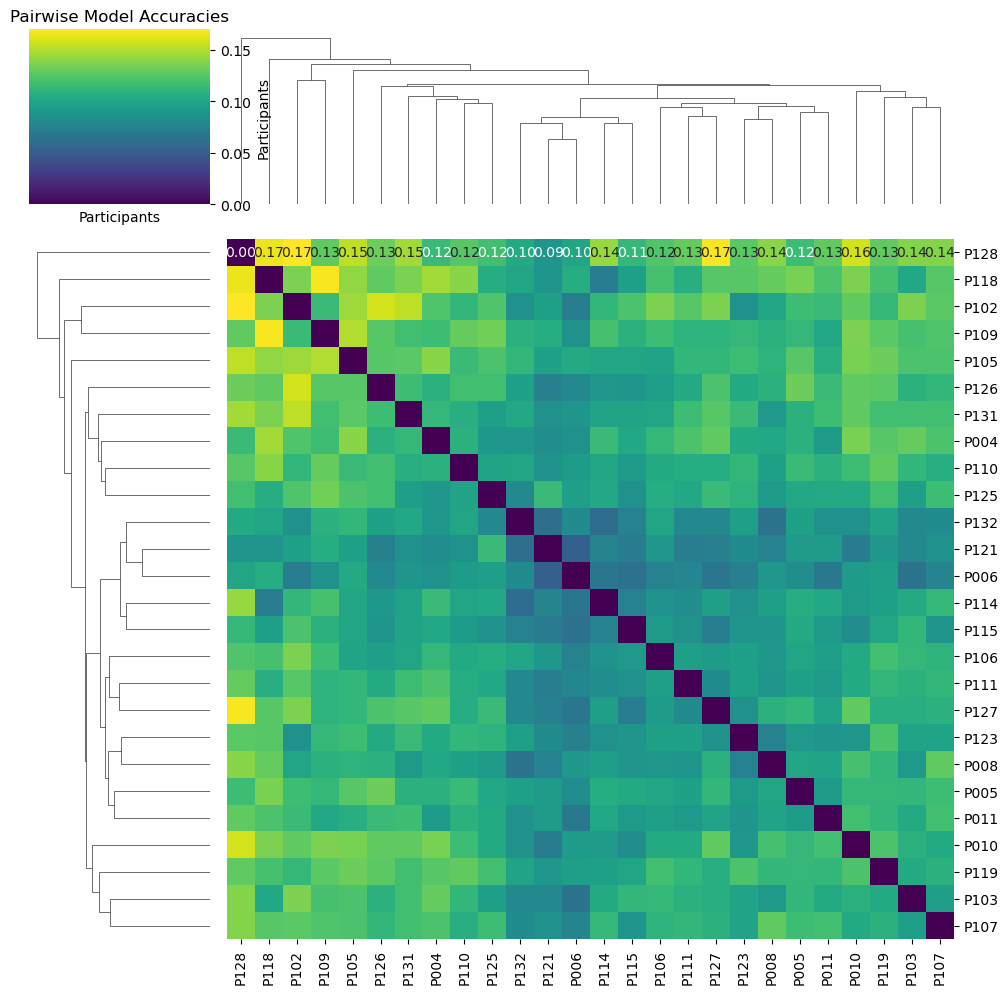

In [72]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOUaccuracies_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

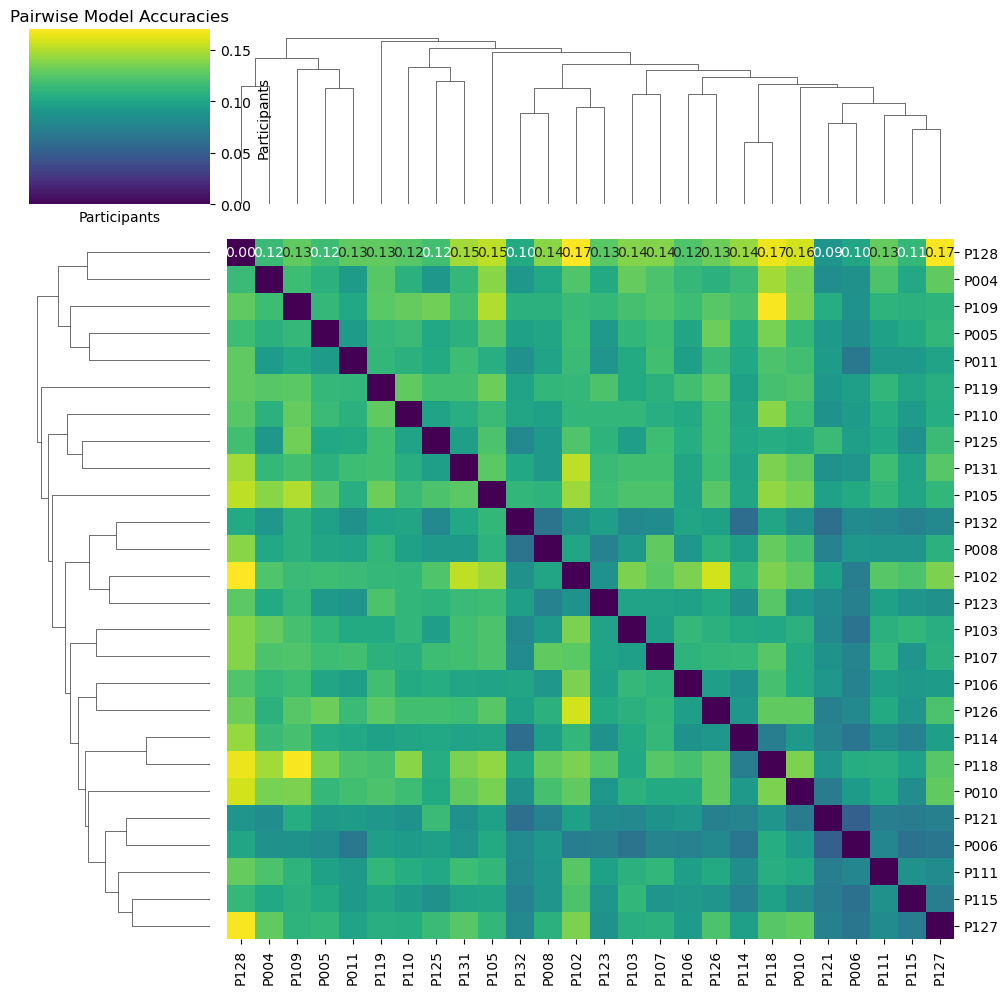

In [73]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOUaccuracies_matrix, metric='correlation', cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

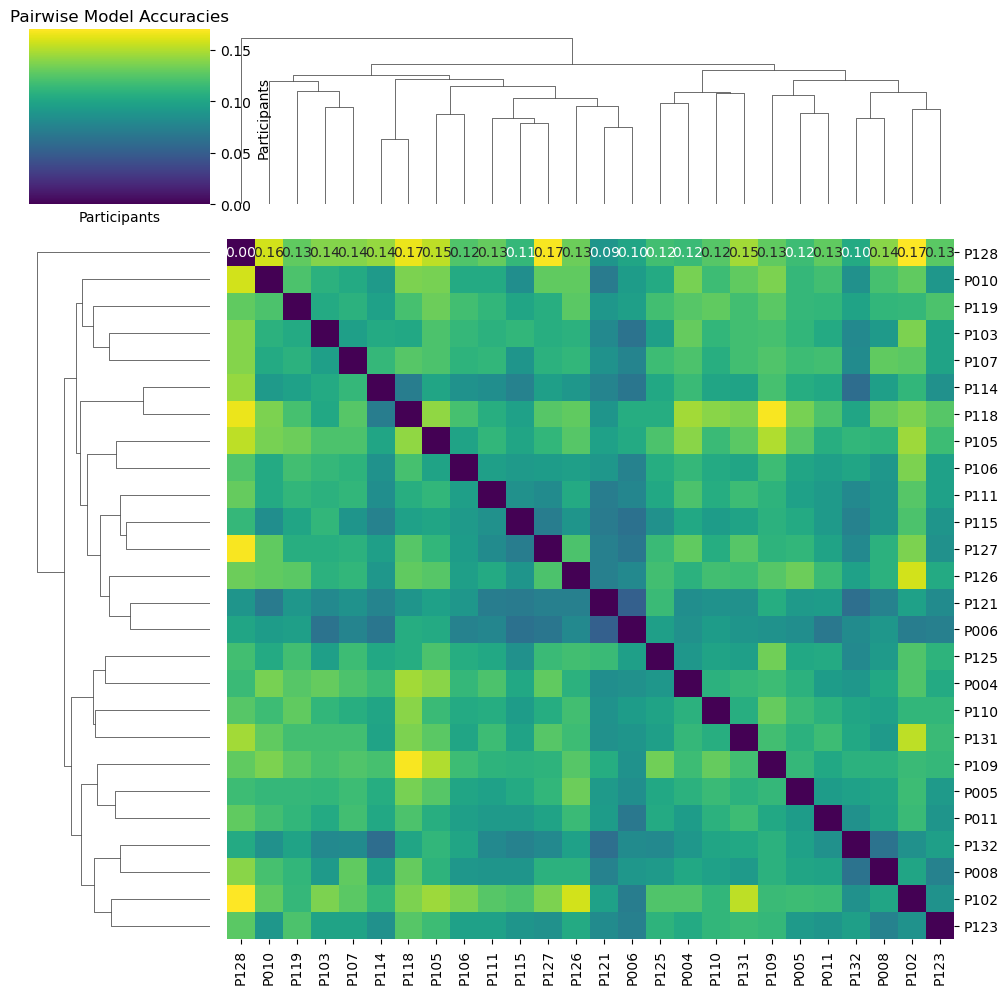

In [74]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOUaccuracies_matrix, metric='cosine', cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
